In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import namedtuple
import warnings

import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler

In [3]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [4]:
gpt = get_pretrained_gpt(size="medium")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

/home/ubuntu/.local/lib/python3.8/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [5]:
gpt.generate("The problem with modern culture is", temperature=.8, device=device)

'The problem with modern culture is that it will chalk up a lot of bad things to its past, and when we say something about the present, in years gone by we often go'

In [9]:
def most_likely(model, fact, k=5):
    subject_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
    relation_ids = tokenizer.encode(fact.relation, return_tensors="pt").to(device)
    input_ids = t.cat((subject_ids, relation_ids), dim=1)
    model_out = model(input_ids)
    target_probs = t.softmax(model_out.logits.squeeze(0), dim=0)
    top_probs, top_ids = t.topk(target_probs, k=k)
    for i in range(k):
        token = tokenizer.decode(top_ids[i])
        print(f"{repr(token).ljust(15)}{top_probs[i]:.2%}")

In [15]:
Fact = namedtuple("Fact", ['subject', 'relation', 'object'])
example_facts = [
    Fact("Pelé", " used to play the sport of", " soccer"),
    Fact("The Eiffel Tower", " is in the city of", " Paris")
]

Input:
'The' ' E' 'iff' 'el' ' Tower' ' is' ' in' ' the' ' city' ' of' 

Prob ability of the correct answer (' Paris')
normal gpt: 61.92%
corrupted:  0.69%


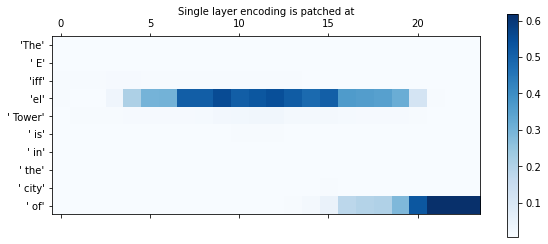

In [16]:
def get_correct_prob(out, correct_id):
    return t.softmax(out.logits[0], dim=-1)[correct_id].item()


def print_tokenized(ids):
    l = tokenizer.batch_decode([[id] for id in ids])
    for t in l:
        print(repr(t), end=" ")
    print()


def run_baseline(model, input_ids, correct_id):
    with HookHandler() as hh:
        for i, block in enumerate(model.blocks):
            hh.add_save_activation_hook(block, key=i)

        logits = model(input_ids)
        correct_prob = get_correct_prob(logits, correct_id)
        return hh.activations, correct_prob


def avg_evaluate(model, input_ids, correct_id, k=5, **kwargs):
    probs = []
    seeds = range(k)
    for seed in seeds:
        t.manual_seed(seed)
        corrupt_out = model.forward_corrupt_and_patch(input_ids, **kwargs)
        probs.append(get_correct_prob(corrupt_out, correct_id))
    return sum(probs) / k


def patching(
    model: GPT2, tokenizer, fact: Fact, k=5, noise_std=0.4, plot=True
):
    if fact.relation[0] != " ":
        warnings.warn(f"The fact relation {fact.relation} does not start with a space")
    if fact.object[0] != " ":
        warnings.warn(f"The fact object {fact.object} does not start with a space")

    subject_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
    relation_ids = tokenizer.encode(fact.relation, return_tensors="pt").to(device)
    subj_len = subject_ids.shape[1]
    input_ids = t.cat((subject_ids, relation_ids), dim=1)
    correct_id = tokenizer.encode(fact.object)
    if len(correct_id) != 1:
        warnings.warn(
            f"The fact object {fact.object} is {len(correct_id)} tokens long, only using first token"
        )
    correct_id = correct_id[0]

    activations, p_baseline = run_baseline(model, input_ids, correct_id)

    corruption = Corruption(subj_len, noise_std)
    p_corrupted = avg_evaluate(
        model,
        input_ids=input_ids,
        correct_id=correct_id,
        k=k,
        corruption=corruption,
    )
    
    print(f"Input:")
    print_tokenized(input_ids[0])

    print(f"\nProb ability of the correct answer ({repr(fact.object)})")
    print(f"normal gpt: {p_baseline:.2%}")
    print(f"corrupted:  {p_corrupted:.2%}")

    n_layers = len(model.blocks)
    n_tokens = input_ids.shape[1]
    avg_prob = np.zeros((n_tokens, n_layers))
    for token in range(n_tokens):
        for layer in range(n_layers):
            patch_value = activations[layer][0, token]
            patch = Patch(token=token, layer=layer, value=patch_value)
            prob = avg_evaluate(
                model,
                input_ids=input_ids,
                correct_id=correct_id,
                k=k,
                patch=patch,
                corruption=corruption,
            )
            avg_prob[token, layer] = prob

    if plot:
        plt.matshow(avg_prob, vmin=p_corrupted, vmax=p_baseline, cmap="Blues")
        l = tokenizer.batch_decode([[id] for id in input_ids[0]])
        plt.yticks(ticks=range(n_tokens), labels=[repr(t) for t in l])
        plt.xlabel("Patching activation at single layer")
        plt.gca().xaxis.set_label_position("top")
        plt.colorbar()
    return avg_prob

probs = patching(
    gpt, tokenizer, example_facts[1], k=10
)

In [13]:
most_likely(gpt, example_facts[0])

' soccer'      25.91%
' football'    10.40%
' basketball'  8.98%
' boxing'      7.50%
' tennis'      6.65%
